In [2]:
%load_ext autoreload
%reload_ext autoreload
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set()
sns.set_style("darkgrid")
from utils import *
import scipy.misc
import glob
import operator

In [3]:
def times100(x):
    return 100 * np.max(x, axis=-1)
def minim(x):
    return np.min(x, axis=-1)

In [4]:
def combine_results_for_error_bars(results, keys_to_combine=None):
    if keys_to_combine is None:
        return results
    
    combined_results = {}
    key_count = {}
    for key in keys_to_combine:
        for (this_key, this_result) in results.items():
            if key in this_key:
                if key in combined_results:
                    for (stat, res) in this_result.items():
                        smaller = min(len(res), combined_results[key][stat].shape[1])
                        combined_results[key][stat] = combined_results[key][stat][:,:smaller]
                        combined_results[key][stat] = np.concatenate((combined_results[key][stat], 
                                                                      np.array([res[:smaller]])), axis=0)
                        key_count[key] += 1
                else:
                    combined_results[key] = {}
                    for stat, res in this_result.items():
                        combined_results[key][stat] = np.array([res])

                    key_count[key] = 1
    return combined_results

In [22]:
log_dir = '../log'
runs = glob.glob("{}/*/".format(log_dir))

datasets = ['cifar-10']
models = ['cnn', 'resnet', 'preact_resnet', 'wresnet', 'densenet']
seeds = [0, 1, 2, 3, 4]
combine_seeds_for_error_bars = True
experiment_names = []

experiments = {}

for dataset in datasets:
    for model in models:
        for seed in seeds:
            experiments['{0}-{1}-{2}'.format(dataset, model, seed)] = '{0}-{1}-{2}'.format(dataset, model, seed)
            if '{0}-{1}'.format(dataset, model) not in experiment_names:
                experiment_names.append('{0}-{1}'.format(dataset, model))
excludes = []
results = {}
for run in runs:
   
    if ((len(experiments) and run.split('/')[-2] in experiments)):
        r = read_results('{}/summary_logs/result_summary_statistics.csv'.format(run))
        if len(r['epoch']):
            results[experiments[run.split('/')[-2]]] = r
            print('Loading {}, {} epochs done'.format(run.split('/')[-2], len(results[experiments[run.split('/')[-2]]]['epoch'])))

if combine_seeds_for_error_bars:
    results = combine_results_for_error_bars(results, 
               keys_to_combine=experiment_names)
    print('Combined results, keys:')
    print(list(results.keys()))

Loading cifar-10-wresnet-2, 200 epochs done
Loading cifar-10-densenet-3, 200 epochs done
Loading cifar-10-resnet-1, 200 epochs done
Loading cifar-10-densenet-4, 200 epochs done
Loading cifar-10-densenet-1, 200 epochs done
Loading cifar-10-resnet-4, 200 epochs done
Loading cifar-10-cnn-2, 200 epochs done
Loading cifar-10-resnet-0, 200 epochs done
Loading cifar-10-cnn-1, 200 epochs done
Loading cifar-10-preact_resnet-4, 200 epochs done
Loading cifar-10-densenet-2, 200 epochs done
Loading cifar-10-preact_resnet-3, 200 epochs done
Loading cifar-10-preact_resnet-2, 200 epochs done
Loading cifar-10-wresnet-3, 200 epochs done
Loading cifar-10-preact_resnet-1, 200 epochs done
Loading cifar-10-wresnet-0, 200 epochs done
Loading cifar-10-resnet-3, 200 epochs done
Loading cifar-10-cnn-4, 200 epochs done
Loading cifar-10-cnn-0, 200 epochs done
Loading cifar-10-preact_resnet-0, 200 epochs done
Loading cifar-10-wresnet-1, 200 epochs done
Loading cifar-10-cnn-3, 200 epochs done
Loading cifar-10-wresn

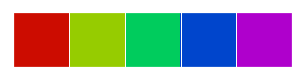

In [23]:
colour_type = 'hls'
if colour_type.lower() == 'hls':
    colours = sns.hls_palette(len(results), l=0.4, s=1)
elif colour_type.lower() == 'bright':
    colours = sns.color_palette('bright', len(results))
elif colour_type.lower() == 'deep':
    colours = sns.color_palette('deep', len(results))
elif colour_type.lower() == 'muted':
    colours = sns.color_palette('muted', len(results))
elif colour_type.lower() == 'pastel':
    colours = sns.color_palette('pastel', len(results))
elif colour_type.lower() == 'cubehelix':
    colours = sns.color_palette('cubehelix', len(results))
elif colour_type.lower() == 'blues':
    colours = sns.color_palette('Blues', len(results))
elif colour_type.lower() == 'reds':
    colours = sns.color_palette('Reds', len(results))
else:
    colours = sns.hls_palette(len(results), l=0.4, s=1)
sns.palplot(colours)


xlims = [0, 200]
stats_to_plot = {
    '{}_loss_c':('Loss (Cross Entropy)', minim, [0.0, 1.2]),    
    '{}_acc':('Accuracy', times100, [0.60, 1.01]),    
}


linewidth = 2.5
w = 1
h = np.ceil(len(stats_to_plot)/w)



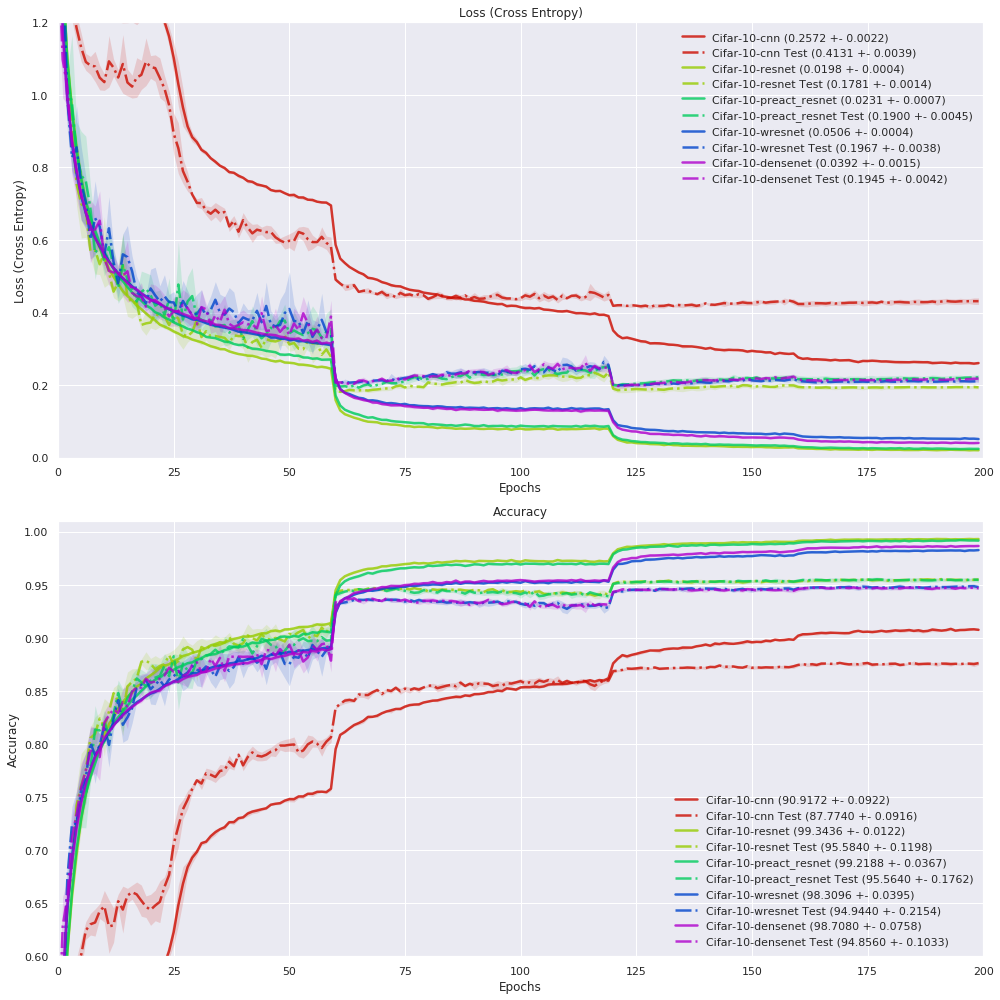

In [24]:
fig = plt.figure(figsize=(14, 7 * h))
ploti = 1
marker=''

for stat, (title, label_function, ylims) in stats_to_plot.items():
    
    ax = fig.add_subplot(h, w, ploti)
    for i, (label, thisresult) in enumerate(results.items()):

        
        if stat.format('train') in thisresult.keys():

            epochs = thisresult['epoch']
            
            
            train_stat = thisresult[stat.format('train')]
            test_stat = thisresult[stat.format('test')]

            if combine_seeds_for_error_bars:
                epochs = epochs[0]
                ax.plot(epochs, 
                        np.mean(train_stat, axis=0), 
                        color=colours[i], 
                        marker=marker,
                        label='{} ({:0.4f} +- {:0.4f})'.format(label, 
                                                    np.mean(label_function(train_stat)),
                                                    np.std(label_function(train_stat))), 
                        alpha=0.8, 
                        linewidth=linewidth * (2 if ('baseline' in label) else 1))
                
                ax.fill_between(epochs,
                               np.mean(train_stat, axis=0) - np.std(train_stat, axis=0),
                               np.mean(train_stat, axis=0) + np.std(train_stat, axis=0),
                               color=colours[i], 
                               alpha=0.15,
                               linewidth=0)

                ax.plot(epochs, np.mean(test_stat, axis=0), 
                        color=colours[i], 
                        linestyle='-.', 
                        marker=marker,
                        label='{} Test ({:0.4f} +- {:0.4f})'.format(label, 
                                                    np.mean(label_function(test_stat)),
                                                    np.std(label_function(test_stat))), 
                        alpha=0.8, 
                        linewidth=linewidth * (2 if ('baseline' in label) else 1))
                ax.fill_between(epochs,
                               np.mean(test_stat, axis=0) - np.std(test_stat, axis=0),
                               np.mean(test_stat, axis=0) + np.std(test_stat, axis=0),
                               color=colours[i], 
                               alpha=0.15,
                               linewidth=0)
            else:
                
                ax.plot(epochs, 
                        train_stat, 
                        color=colours[i], 
                        marker=marker,
                        label='{} ({:0.4f})'.format(label, 
                                                    label_function(train_stat)), 
                        alpha=0.8, 
                        linewidth=linewidth * (2 if ('baseline' in label) else 1))

                ax.plot(epochs, 
                        test_stat, 
                        color=colours[i], 
                        linestyle='-.', 
                        marker=marker,
                        label='{} Test ({:0.4f})'.format(label, 
                                                         label_function(test_stat)), 
                        alpha=0.8, 
                        linewidth=linewidth * (2 if ('baseline' in label) else 1))


    ax.set_ylim(ylims)
    ax.set_xlim(xlims)
    ax.set_xlabel('Epochs')
    ax.set_ylabel(title)
    ax.set_title('{}'.format(title))

    ax.legend(frameon=False, ncol=1)
    ploti+= 1
fig.tight_layout()
fig.savefig('cifar-10-results.pdf')